In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)


from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

### 1. Simulating the data

In [17]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**5
n_host = 200
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 0  # 0 if no intercept

power_x, power_x_t = 1, 1
causal_param_first_index = 3 + include_intercept  # 4 if including intercept
outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 4 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    + 0 * X["X_2"] * T  # causal
    + eps
)
if include_intercept:
    true_params = np.array([1, 1, -1, 1, 4, 2, 2, 0])  # intercept, non-causal => 0
else:
    true_params = np.array([1, -1, 1, 4, 2, 2, 0])  # copied from above
std_true_y = 1  # Standard deviation for the true Y

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
# p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 - 2*X_0 + eps)

Simulation parameters

In [18]:
# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 1, 0, 0, 1, 0, 0, 0])
else:
    prior_mean = np.array([1, 0, 0, 1, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}

# Hyperparameters for Bayesian update on host
warmup_steps = 50
max_tree_depth = 5

# Number of samples used to estimate outer expectation
n_samples_for_expectation = 50
m_samples_for_expectation = 1000

# Incorporating sqrt constraint into MCMC samples
n_mc = n_samples_for_expectation * (m_samples_for_expectation + 1)

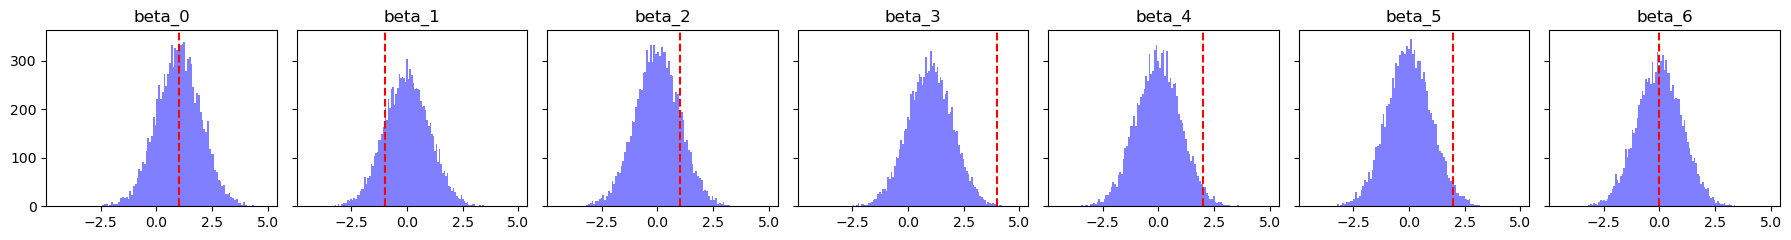

In [19]:
# sample from the prior:
beta_samples = rng.multivariate_normal(
    prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
)
# plot the prior samples and true_params as red crosses:
# let's do d subplots
ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# on each subplot, plot the prior samples and the true params
for i in range(d):
    fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
    fig[i].axvline(true_params[i], color="red", linestyle="--")
    fig[i].set_title(f"beta_{i}")

plt.tight_layout()
plt.show()

In [20]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1  # n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


data_parameters = {
    "n_both_candidates_list": n_both_candidates_list,
    "proportion": proportion,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form 

In [21]:
n_seeds = 3

text_l1 = "p_assigned_to_host=p_assigned_to_cand2, n_samples_for_expectation = 30,"
text_l2 = "m_samples_for_expectation = 500, n_host = 200, sigma_prior = 1, sigma_rand_error = 1,"
text_l3 = "outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T + eps"

In [22]:
exact_data = generate_exact_synthetic_data_varying_sample_size(
    data_parameters, include_intercept=bool(include_intercept)
)
exact_data[200]["host"]

,X_0,X_1,X_2,T,T*X_0,T*X_1,T*X_2,Y
0,0.768645,4.546122,0.168739,0.0,0.000000,0.000000,0.000000,-3.888444
1,0.779178,4.587682,0.062036,0.0,0.000000,0.000000,0.000000,-4.630981
2,0.763735,2.894964,0.005906,1.0,0.763735,2.894964,0.005906,9.448291
3,0.764843,4.792008,0.060238,1.0,0.764843,4.792008,0.060238,10.457582
4,0.813525,3.805298,0.139436,1.0,0.813525,3.805298,0.139436,11.968929
...,...,...,...,...,...,...,...,...
195,0.949080,4.317837,0.094035,0.0,0.000000,0.000000,0.000000,-3.568182
196,0.741743,2.925925,0.003071,1.0,0.741743,2.925925,0.003071,8.828471
197,0.738904,3.855328,0.019918,0.0,0.000000,0.000000,0.000000,-2.695747
198,0.819289,3.963779,0.043719,1.0,0.819289,3.963779,0.043719,9.809004


In [23]:
dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = (
    linear_eig_closed_form_varying_sample_size(
        exact_data,
        data_parameters,
        prior_hyperparameters,
    )
)

For a sample size of 200
 % treated in host: 67%
 % treated in exact_twin_untreated: 0%
 % treated in exact_twin_treated: 100%
 % treated in exact_twin: 67%
 % treated in exact_complementary: 32%
For a sample size of 500
 % treated in host: 71%
 % treated in exact_twin_untreated: 0%
 % treated in exact_twin_treated: 100%
 % treated in exact_twin: 67%
 % treated in exact_complementary: 28%
For a sample size of 1000
 % treated in host: 73%
 % treated in exact_twin_untreated: 0%
 % treated in exact_twin_treated: 100%
 % treated in exact_twin: 73%
 % treated in exact_complementary: 27%


In [24]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []

for i in range(n_seeds):
    nonexact_data = generate_synthetic_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept)
    )
    EIGs = linear_eig_closed_form_varying_sample_size(  # CHECK what this does
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )

EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  # [6, 3]
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)

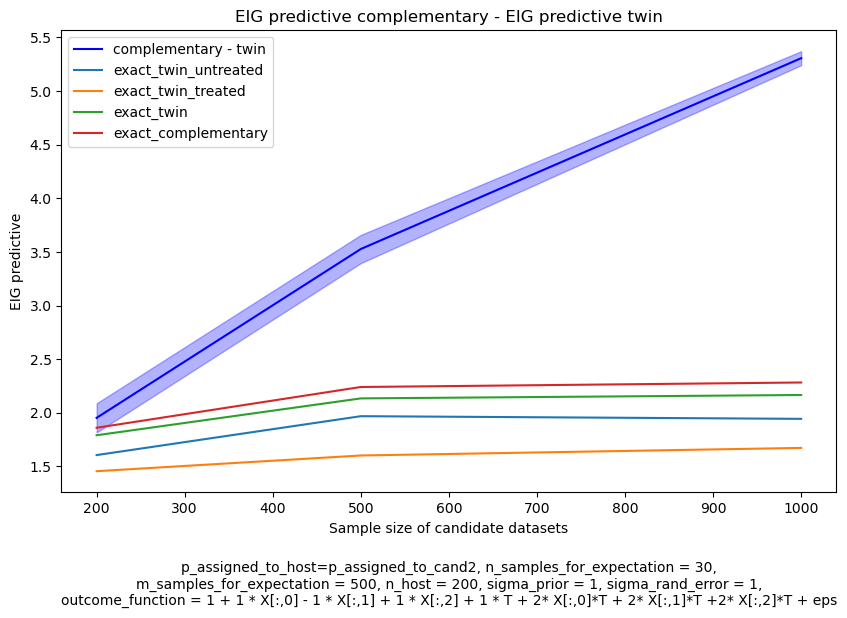

In [25]:
# path_obs_closed_form = '/Users/lucile/causal_info_gain/plots/eig_obs_closed_form'
# WHAT is the error bound?
path_obs_closed_form = ""

plot_array(
    x=n_both_candidates_list,  # sample sizes
    arr=EIG_obs_closed_form_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG predictive"],
    dict_additional_plots=dict_additional_plots_obs_closed_from,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG predictive complementary - EIG predictive twin",
)

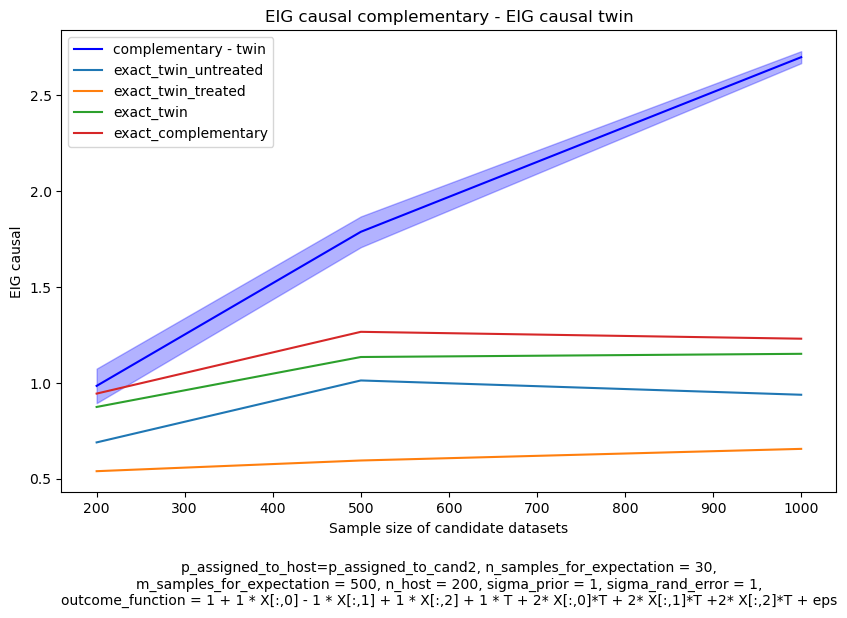

In [26]:
# path_caus_closed_form = '/Users/lucile/causal_info_gain/plots/eig_caus_closed_form'
path_caus_closed_form = 0

plot_array(
    n_both_candidates_list,
    EIG_caus_closed_form_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG causal"],
    dict_additional_plots=dict_additional_plots_caus_closed_from,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG causal complementary - EIG causal twin",
)

### 2. EIG from samples for varying sample sizes

In [12]:
n_samples_outer_expectation = 100
n_samples_inner_expectation = 200
n_causal_outer_exp = 100
n_causal_inner_exp = 200

sampling_parameters = {
    "n_samples_inner_expectation": n_samples_inner_expectation,
    "n_samples_outer_expectation": n_samples_outer_expectation,
    "n_causal_inner_exp": n_causal_inner_exp,
    "n_causal_outer_exp": n_causal_outer_exp,
}

In [15]:
dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = (
    linear_eig_from_samples_exact_datasets(
        exact_data,
        data_parameters,
        prior_hyperparameters,
        n_mc,
        sampling_parameters,
    )
)

In [ ]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range(n_seeds):
    EIG_obs_samples, EIG_caus_samples = linear_eig_from_samples_varying_sample_size(
        data, data_parameters, prior_hyperparameters, sampling_parameters
    )
    if len(EIG_obs_samples_across_seeds) == 0:
        EIG_obs_samples_across_seeds = EIG_obs_samples
        EIG_caus_samples_across_seeds = EIG_caus_samples
    else:
        EIG_obs_samples_across_seeds = np.vstack(
            (EIG_obs_samples_across_seeds, EIG_obs_samples)
        )
        EIG_caus_samples_across_seeds = np.vstack(
            (EIG_caus_samples_across_seeds, EIG_caus_samples)
        )

In [ ]:
text_l1 = "p_assigned_to_host=p_assigned_to_cand2, approx 0.8 treated in host"
text_l2 = (
    "n_samples_inner_expectation = "
    + str(n_samples_inner_expectation)
    + "n_samples_outer_expectation = "
    + str(n_samples_outer_expectation)
    + ", n_host = "
    + str(n_host)
    + ", sigma_prior = sigma_rand_error = "
    + str(sigma_rand_error)
)
text_l4 = (
    "n_host = 200, sigma_prior = sigma_rand_error = 1, n_causal_inner_exp = "
    + str(n_causal_inner_exp)
)

In [ ]:
# path_obs_samples = '/Users/lucile/causal_info_gain/plots/eig_obs_samples'
path_obs_samples = 0

plot_array(
    n_both_candidates_list,
    EIG_obs_samples_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG predictive"],
    dict_additional_plots=dict_additional_plots_obs_from_samples,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3 + "\n" + text_l4,
    title="EIG predictive complementary - EIG predictive twin",
)

In [ ]:
# path_caus_samples = '/Users/lucile/causal_info_gain/plots/eig_caus_samples'
path_caus_samples = 0

plot_array(
    n_both_candidates_list,
    EIG_caus_samples_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG causal"],
    dict_additional_plots=dict_additional_plots_caus_from_samples,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3 + "\n" + text_l4,
    title="EIG causal_complementary - EIG causal_twin",
)